In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

Mounted at /content/drive


In [2]:
pip install split-folders

In [3]:
import splitfolders

In [4]:
bus_dir = os.path.join('/content/drive/MyDrive/dataset/bus')
plane_dir = os.path.join('/content/drive/MyDrive/dataset/plane')
ship_dir = os.path.join('/content/drive/MyDrive/dataset/ship')

In [5]:
bus = os.listdir(bus_dir)
plane = os.listdir(plane_dir)
ship = os.listdir(ship_dir)

In [6]:
print('total training bus images:', len(bus))
print('total training plane images:', len(plane))
print('total training ship images:', len(ship))

total training bus images: 1721
total training plane images: 1611
total training ship images: 992


In [7]:
print('total dataset: ', len(bus) + len(plane) + len(ship))

total dataset:  4324


In [8]:
base_dir = '/content/drive/MyDrive/dataset'
splitfolders.ratio(base_dir, output=f'{base_dir}/split', seed=42, ratio=(0.8, 0.2), group_prefix=None)

Copying files: 4324 files [04:03, 17.75 files/s]


In [15]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(300,300,3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 149, 149, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 73, 73, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 71, 71, 64)       

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1/255)

In [11]:
train = '/content/drive/MyDrive/dataset/split/train'
val = '/content/drive/MyDrive/dataset/split/val'

train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(300,300),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val,
    target_size=(300,300),
    batch_size=32,
    class_mode='categorical'
)

Found 3453 images belonging to 3 classes.
Found 866 images belonging to 3 classes.


In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') > 0.85 and logs.get('val_accuracy') > 0.85):
      print("\nAkurasi telah melebihi 85%!")
      self.model.stop_training = True

callbacks = myCallback()

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
history = model.fit(
    train_generator,
    steps_per_epoch=32,
    epochs=50,
    batch_size=70,
    validation_data=validation_generator,
    validation_steps=8,
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/50
32/32 [==============================] - 163s 5s/step - loss: 1.0882 - accuracy: 0.3683 - val_loss: 1.0829 - val_accuracy: 0.3711
Epoch 2/50
32/32 [==============================] - 160s 5s/step - loss: 0.9973 - accuracy: 0.4102 - val_loss: 1.0551 - val_accuracy: 0.4062
Epoch 3/50
32/32 [==============================] - 175s 5s/step - loss: 0.9113 - accuracy: 0.5469 - val_loss: 0.6572 - val_accuracy: 0.6836
Epoch 4/50
32/32 [==============================] - 163s 5s/step - loss: 0.7864 - accuracy: 0.6279 - val_loss: 0.6355 - val_accuracy: 0.7188
Epoch 5/50
32/32 [==============================] - 167s 5s/step - loss: 0.6802 - accuracy: 0.6846 - val_loss: 0.4434 - val_accuracy: 0.8359
Epoch 6/50
32/32 [==============================] - 176s 5s/step - loss: 0.6552 - accuracy: 0.6982 - val_loss: 0.4978 - val_accuracy: 0.8281
Epoch 7/50
32/32 [==============================] - 165s 5s/step - loss: 0.5598 - accuracy: 0.7607 - val_loss: 0.3473 - val_accuracy: 0.8633
Epoch 8/50
32

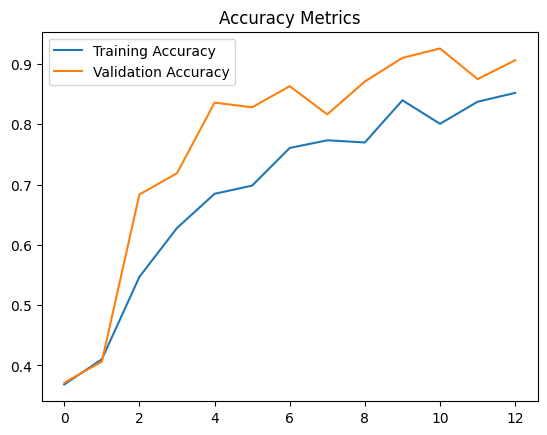

In [19]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Metrics')
plt.legend()
plt.show()

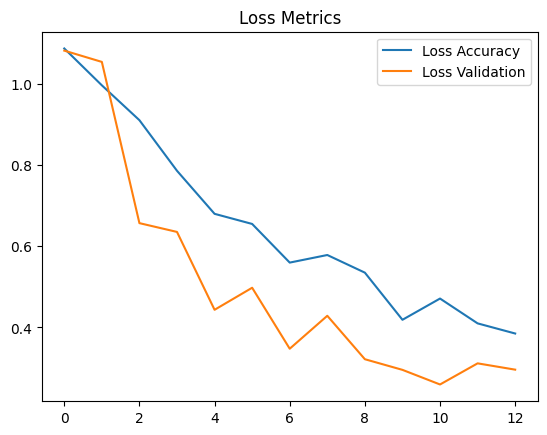

In [20]:
plt.plot(history.history['loss'], label='Loss Accuracy')
plt.plot(history.history['val_loss'], label='Loss Validation')
plt.title('Loss Metrics')
plt.legend()
plt.show()

In [21]:
export_dir = "/content/drive/MyDrive/dataset"
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

with tf.io.gfile.GFile('submission.tflite', 'wb') as f:
    f.write(tflite_model)